In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from BaseModel import *
from LlamaModel import *
import torch
import matplotlib.pyplot as plt


/home/kamalika/miniconda3/envs/pyt/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_id = "meta-llama/Meta-Llama-3-8B-Instruct"
#model_id = "facebook/opt-125m"
#model_id = "openai/gpt-oss-20b"
llama = LlamaModel(model_id)
_ = llama.load()


oading checkpoint shards: 100%|██████████| 4/4 [00:04<00:00,  1.17s/it]

In [3]:
#print(llama.model.model.layers[0].self_attn)
print(llama.model)


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (norm): LlamaRMSNorm((4096,), eps=1e-05)
    (rotary_

In [4]:
prompt = "What is the capital of france?" 
tokenized_prompt = llama.tokenizer(llama.format_prompt(prompt), return_tensors='pt')
print(tokenized_prompt)

print(tokenized_prompt['input_ids'].shape)
print(tokenized_prompt['attention_mask'].shape)

{'input_ids': tensor([[128000, 128000, 128006,    882, 128007,    271,   3923,    374,    279,
           6864,    315,  48687,     30, 128009, 128006,  78191, 128007,    271]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
torch.Size([1, 18])
torch.Size([1, 18])


In [5]:

with torch.no_grad():
    y = llama.model(tokenized_prompt['input_ids'], output_attentions=True)
    print(y)

CausalLMOutputWithPast(loss={'logits': tensor([[[  4.9688,   6.1562,  10.8125,  ...,  -3.6406,  -3.6406,  -3.6406],
         [  4.9688,   6.1562,  10.8125,  ...,  -3.6406,  -3.6406,  -3.6406],
         [ -2.6250,   1.6250,  -2.3438,  ...,   6.2188,   6.2188,   6.2188],
         ...,
         [-15.5000, -12.3750, -12.5000,  ...,  10.5625,  10.5625,  10.5625],
         [ -6.0000,  -3.6562,  -5.0625,  ...,   7.6875,   7.6875,   7.6875],
         [  2.6562,   6.2500,   4.1875,  ...,   4.1250,   4.1250,   4.1250]]],
       dtype=torch.bfloat16), 'past_key_values': DynamicCache(layers=[DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, Dynamic

In [6]:
attentions = y.attentions
print(len(attentions))
print(attentions[0][0][0].shape)


32
torch.Size([18, 18])
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5156, 0.4844, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4395, 0.4648, 0.0962, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3828, 0.4766, 0.0645, 0.0776, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2930, 0.3418, 0.1436, 0.1250, 0.0972, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2354, 0.3379, 0.1016, 0.0791, 0.0537, 0.1934, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]

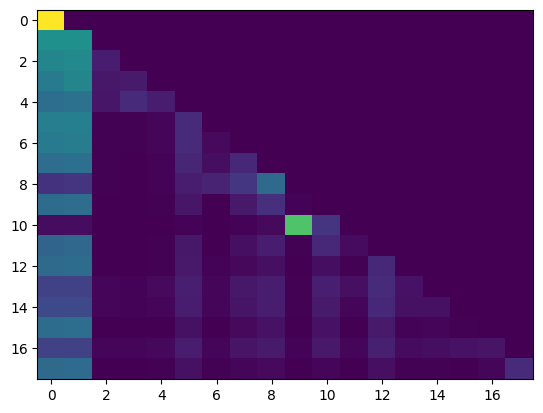

In [16]:
plt.imshow(attentions[0][0][6].to(torch.float32).numpy(), cmap='viridis', aspect='auto')
plt.show()
